In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib.pylab import rcParams
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE 

# DataSet

## Attribute Information

Atributes:<br>
```
Paragraph
```

## Pre Processing

In [77]:
data = pd.read_csv('cm1.csv')
# data = pd.read_csv('kc1.csv')

In [78]:
data.head()

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,Class
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,24.0,5.0,1.0,3.0,63.0,309.13,0.11,9.50,32.54,2936.77,...,1,0,6,0,15.0,15.0,44.0,19.0,9.0,False
3,20.0,4.0,4.0,2.0,47.0,215.49,0.06,16.00,13.47,3447.89,...,0,0,3,0,16.0,8.0,31.0,16.0,7.0,False
4,24.0,6.0,6.0,2.0,72.0,346.13,0.06,17.33,19.97,5999.58,...,0,0,3,0,16.0,12.0,46.0,26.0,11.0,False


In [79]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data.Class = encoder.fit_transform(data.Class)

## Over-Sampling imbalanced data

In [80]:
X = data.iloc[:, :-1].values
y = data.Class.values
print('Original dataset shape {}'.format(Counter(y)))

Original dataset shape Counter({0: 449, 1: 49})


In [81]:
sm = SMOTE(random_state=42)
X, y = sm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y)))

Resampled dataset shape Counter({0: 449, 1: 449})


In [82]:
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

# Bagging & Random Subspace

In [83]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import f1_score

In [84]:
rcParams['figure.figsize'] = 12, 3

In [85]:
from sklearn.model_selection import StratifiedKFold

In [86]:
def Generate_Analysis(X, y):
    name1 = ['Bagging', 'Random Subspace']
    name2 = ['Árvores de Decisão', 'Perceptron']
    pos = ['lower left', 'upper right']
    features = [1.0, 0.5]
    models = [DecisionTreeClassifier(), Perceptron(tol = 0.0001, max_iter = 10000)]
    sizes = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
    for f, feature in enumerate(features):
        for m, model in enumerate(models):
            skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
            metrics = np.zeros((len(sizes), 4))
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                for i, size in enumerate(sizes):
                    # All data points
                    bg = BaggingClassifier(model,
                                             max_samples = size,
                                             max_features = feature,
                                             n_estimators = 100,
                                             random_state = 42)
                    bg.fit(X_train, y_train)
                    y_pred = bg.predict(X_test)
                    metrics[i, :] += [bg.score(X_test, y_test),
                        roc_auc_score(y_test, bg.predict_proba(X_test)[:,1]),
                          geometric_mean_score(y_test, y_pred),
                          f1_score(y_test, y_pred)]
            metrics = metrics / skf.n_splits
                       
            barWidth = 0.1
            # Set position of bar on X axis
            r1 = np.arange(metrics.shape[0])
            r2 = [x + barWidth for x in r1]
            r3 = [x + barWidth for x in r2]
            r4 = [x + barWidth for x in r3]

            # Make the plot
            plt.bar(r1, metrics[:, 0], width=barWidth, edgecolor='white', label='Acurácia')
            plt.bar(r2, metrics[:, 1], width=barWidth, edgecolor='white', label='AUC')
            plt.bar(r3, metrics[:, 2], width=barWidth, edgecolor='white', label='G-Mean')
            plt.bar(r4, metrics[:, 3], width=barWidth, edgecolor='white', label='F-Measure')

            # Add xticks on the middle of the group bars
            plt.ylim([0.6, 1.01])
            plt.xlabel('Porcentagem de dados no treinamento')
            plt.ylabel('Escore')
            plt.xticks([r + barWidth for r in range(metrics.shape[0])], ['100%', '90%', '80%', '70%', '60%', '50%'])

            # Create legend & Show graphic
            plt.legend(loc = pos[m])
            plt.title(name1[f]+ ' - '+ name2[m])
            plt.show()
            
            df = pd.DataFrame(data = metrics, index = sizes, columns = ['Acurácia', 'AUC', 'G-Mean', 'F-Measure'])
            print(df)

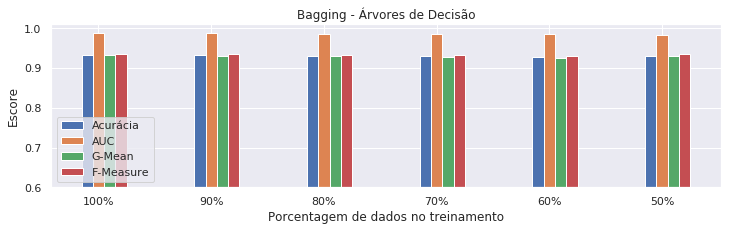

     Acurácia       AUC    G-Mean  F-Measure
1.0  0.933157  0.986749  0.931867   0.935868
0.9  0.931995  0.987335  0.930661   0.934903
0.8  0.930934  0.986230  0.929516   0.933741
0.7  0.929798  0.984185  0.928216   0.933067
0.6  0.927576  0.984595  0.925802   0.931095
0.5  0.930909  0.983911  0.929407   0.934061


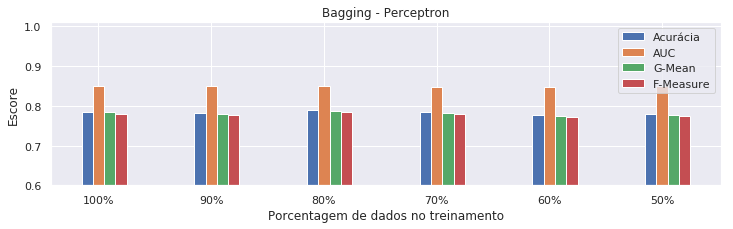

     Acurácia       AUC    G-Mean  F-Measure
1.0  0.785152  0.850444  0.783393   0.780129
0.9  0.781793  0.850059  0.779628   0.775942
0.8  0.788460  0.849351  0.786826   0.783717
0.7  0.785126  0.847946  0.782594   0.778204
0.6  0.777273  0.846981  0.774907   0.771879
0.5  0.779545  0.849004  0.776797   0.772983


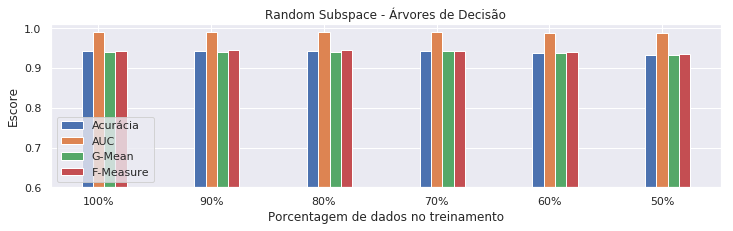

     Acurácia       AUC    G-Mean  F-Measure
1.0  0.942096  0.991613  0.941392   0.943788
0.9  0.942096  0.991469  0.941208   0.944016
0.8  0.942071  0.991166  0.941358   0.944007
0.7  0.942096  0.990323  0.941419   0.943890
0.6  0.938712  0.988177  0.937708   0.941099
0.5  0.933157  0.986994  0.931919   0.935848


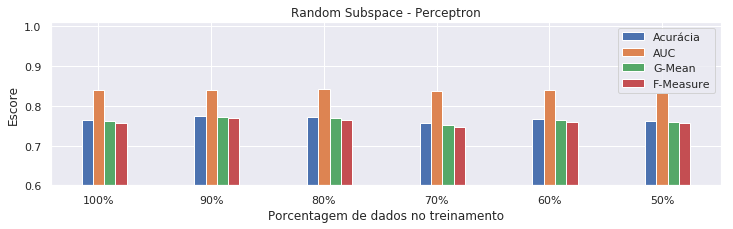

     Acurácia       AUC    G-Mean  F-Measure
1.0  0.763990  0.838998  0.761123   0.756073
0.9  0.775101  0.840426  0.772158   0.768145
0.8  0.771717  0.842984  0.768769   0.764983
0.7  0.756212  0.838306  0.751787   0.745869
0.6  0.766237  0.839242  0.763450   0.759561
0.5  0.761717  0.832929  0.758314   0.755770


In [87]:
Generate_Analysis(X,y)